In [ ]:
!git clone https://github.com/A03ki/f-AnoGAN.git

Cloning into 'f-AnoGAN'...
remote: Enumerating objects: 255, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 255 (delta 27), reused 41 (delta 24), pack-reused 207
Receiving objects: 100% (255/255), 239.34 KiB | 10.88 MiB/s, done.
Resolving deltas: 100% (139/139), done.


In [ ]:
%cd f-AnoGAN

/content/f-AnoGAN


In [ ]:
!python /content/f-AnoGAN/setup.py install

running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based t

In [ ]:
%cd your_own_dataset

/content/f-AnoGAN/your_own_dataset


##Install GZ2 Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
from PIL import Image
import cv2
import pandas as pd
import numpy as np
import scipy
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

!pip install Augmentor
import Augmentor

import pickle

In [ ]:
%cd /content/f-AnoGAN/your_own_dataset/

/content/f-AnoGAN/your_own_dataset


In [ ]:
#unzip images from zip file
!unzip /content/drive/MyDrive/images_gz2.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/97514.jpg        
  inflating: __MACOSX/images/._97514.jpg  
  inflating: images/97515.jpg        
  inflating: __MACOSX/images/._97515.jpg  
  inflating: images/97516.jpg        
  inflating: __MACOSX/images/._97516.jpg  
  inflating: images/97517.jpg        
  inflating: __MACOSX/images/._97517.jpg  
  inflating: images/97518.jpg        
  inflating: __MACOSX/images/._97518.jpg  
  inflating: images/97519.jpg        
  inflating: __MACOSX/images/._97519.jpg  
  inflating: images/9752.jpg         
  inflating: __MACOSX/images/._9752.jpg  
  inflating: images/97520.jpg        
  inflating: __MACOSX/images/._97520.jpg  
  inflating: images/97521.jpg        
  inflating: __MACOSX/images/._97521.jpg  
  inflating: images/97523.jpg        
  inflating: __MACOSX/images/._97523.jpg  
  inflating: images/97524.jpg        
  inflating: __MACOSX/images/._97524.jpg  
  inflating: images/97525.jpg        
  inflating: __MACOSX

In [ ]:
#delete the __MACOSX folder & its images
shutil.rmtree("/content/f-AnoGAN/your_own_dataset/__MACOSX")

In [ ]:
#df has all the important features about each image
df = pd.read_csv('/content/drive/MyDrive/gz2_hart16.csv')

#df2 has the asset_id which is the image file name
df2 = pd.read_csv("/content/drive/MyDrive/gz2_filename_mapping.csv")

In [ ]:
#In order to remove df2..

#rename df's "dr7objid" column to just "objid" (Object ID)
df.rename(columns={"dr7objid": "objid"}, inplace=True)

#merge in the "asset_id" column from df2 into df
df = df.merge(df2[['objid', 'asset_id']], on='objid', how='left')

In [ ]:
# Create a new column to group classes
def group_classes(class_name):
    if class_name.startswith("E"):
        return "Elliptical"
    elif class_name.startswith("S"):
        return "Spiral"
    elif class_name.startswith("A"):
        return "Anomalous"
    else:
        return "Other"

#new column ("class_group") applies a function to group classes
df["class_group"] = df["gz2_class"].apply(group_classes)

In [ ]:
from tqdm import tqdm
# Specify the base directory where subfolders will be created
base_directory = '/content/f-AnoGAN/your_own_dataset/images_grouped'

# Create the base directory if it doesn't exist
os.makedirs(base_directory, exist_ok=True)

# Get the unique class_group values from the DataFrame
unique_classes = df['class_group'].unique()

# Iterate through each unique class_group value
for class_name in tqdm(unique_classes, desc="Processing classes"):
    # Exclude invalid class names (e.g., .ipynb_checkpoints)
    if class_name.startswith('.'):
        continue

    # Create a subdirectory for the current class
    class_directory = os.path.join(base_directory, class_name)
    os.makedirs(class_directory, exist_ok=True)

    # Filter the DataFrame for the current class_group
    class_df = df[df['class_group'] == class_name]

    # Iterate through the asset_id values for the current class
    for asset_id in tqdm(class_df['asset_id'], desc=f"Processing {class_name} images"):
        # Construct the image path
        image_path = f"/content/f-AnoGAN/your_own_dataset/images/{asset_id}.jpg"

        # Check if the image exists
        if os.path.exists(image_path):
            # Move the image to the corresponding subdirectory
            new_image_path = os.path.join(class_directory, f"{asset_id}.jpg")
            shutil.move(image_path, new_image_path)
        else:
            print(f"Image for asset_id {asset_id} not found.")

Processing Spiral images:  10%|█         | 14696/141430 [00:00<00:05, 21260.42it/s]

Image for asset_id 215414 not found.



Processing Spiral images:  17%|█▋        | 24117/141430 [00:01<00:05, 22487.18it/s]

Image for asset_id 249103 not found.
Image for asset_id 99870 not found.



Processing Spiral images:  25%|██▌       | 35738/141430 [00:01<00:04, 22928.32it/s]

Image for asset_id 50643 not found.



Processing Spiral images:  40%|███▉      | 56305/141430 [00:02<00:03, 23516.52it/s]

Image for asset_id 95667 not found.



Processing Spiral images:  49%|████▊     | 68678/141430 [00:03<00:03, 23483.46it/s]

Image for asset_id 15246 not found.



Processing Spiral images:  64%|██████▍   | 91041/141430 [00:04<00:02, 17076.15it/s]

Image for asset_id 203684 not found.



Processing Spiral images:  71%|███████▏  | 101004/141430 [00:05<00:02, 15592.21it/s]


Image for asset_id 293833 not found.


Processing Spiral images:  79%|███████▉  | 112301/141430 [00:05<00:01, 16263.90it/s]


Image for asset_id 252457 not found.
Image for asset_id 30336 not found.


Processing Spiral images:  95%|█████████▌| 134905/141430 [00:07<00:00, 13734.08it/s]

Image for asset_id 274093 not found.
Image for asset_id 274564 not found.
Image for asset_id 274709 not found.
Image for asset_id 274964 not found.
Image for asset_id 275032 not found.
Image for asset_id 275917 not found.
Image for asset_id 275972 not found.
Image for asset_id 275973 not found.
Image for asset_id 276498 not found.
Image for asset_id 276927 not found.
Image for asset_id 277280 not found.
Image for asset_id 277669 not found.
Image for asset_id 278074 not found.
Image for asset_id 278075 not found.
Image for asset_id 280163 not found.
Image for asset_id 280856 not found.
Image for asset_id 281128 not found.
Image for asset_id 281129 not found.
Image for asset_id 281130 not found.
Image for asset_id 282534 not found.
Image for asset_id 283507 not found.
Image for asset_id 283829 not found.
Image for asset_id 284390 not found.
Image for asset_id 286733 not found.
Image for asset_id 286946 not found.
Image for asset_id 287209 not found.
Image for asset_id 287445 not found.
I


Processing Elliptical images:   3%|▎         | 3016/97670 [00:00<00:06, 15313.43it/s]

Image for asset_id 26603 not found.



Processing Elliptical images:  16%|█▋        | 16088/97670 [00:00<00:03, 22617.96it/s]

Image for asset_id 59270 not found.



Processing Elliptical images:  24%|██▍       | 23566/97670 [00:01<00:03, 24137.23it/s]

Image for asset_id 219381 not found.



Processing Elliptical images:  41%|████▏     | 40326/97670 [00:01<00:02, 23396.84it/s]

Image for asset_id 203682 not found.



Processing Elliptical images:  64%|██████▍   | 62277/97670 [00:02<00:01, 24665.82it/s]

Image for asset_id 92317 not found.
Image for asset_id 81483 not found.



Processing Elliptical images:  91%|█████████ | 88851/97670 [00:04<00:00, 22382.00it/s]

Image for asset_id 274131 not found.
Image for asset_id 274197 not found.
Image for asset_id 275615 not found.
Image for asset_id 275971 not found.
Image for asset_id 278078 not found.
Image for asset_id 278111 not found.
Image for asset_id 278702 not found.
Image for asset_id 284389 not found.
Image for asset_id 285937 not found.
Image for asset_id 287211 not found.
Image for asset_id 287247 not found.
Image for asset_id 287733 not found.
Image for asset_id 288793 not found.
Image for asset_id 288795 not found.
Image for asset_id 289083 not found.
Image for asset_id 293322 not found.
Image for asset_id 293324 not found.



Processing classes:  67%|██████▋   | 2/3 [00:12<00:06,  6.10s/it]

Image for asset_id 275883 not found.
Image for asset_id 282536 not found.
Image for asset_id 284172 not found.
Image for asset_id 288961 not found.



Processing classes: 100%|██████████| 3/3 [00:12<00:00,  4.31s/it]

Image for asset_id 222471 not found.
Image for asset_id 7350 not found.
Image for asset_id 59271 not found.
Image for asset_id 33878 not found.
Image for asset_id 203731 not found.
Image for asset_id 285103 not found.
Image for asset_id 99869 not found.
Image for asset_id 102663 not found.
Image for asset_id 102665 not found.
Image for asset_id 15247 not found.
Image for asset_id 249590 not found.
Image for asset_id 59269 not found.
Image for asset_id 33877 not found.
Image for asset_id 293834 not found.
Image for asset_id 293831 not found.
Image for asset_id 33876 not found.
Image for asset_id 198041 not found.
Image for asset_id 216810 not found.
Image for asset_id 252151 not found.
Image for asset_id 218989 not found.
Image for asset_id 221376 not found.
Image for asset_id 203683 not found.
Image for asset_id 7351 not found.
Image for asset_id 10959 not found.
Image for asset_id 26606 not found.
Image for asset_id 273522 not found.
Image for asset_id 191283 not found.
Image for asse

In [ ]:
os.makedirs('/content/f-AnoGAN/your_own_dataset/images_grouped/Normal')

In [ ]:
source_dir = '/content/f-AnoGAN/your_own_dataset/images_grouped/Elliptical'
target_dir = '/content/f-AnoGAN/your_own_dataset/images_grouped/Normal'

file_names = os.listdir(source_dir)

for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

In [ ]:
source_dir = '/content/f-AnoGAN/your_own_dataset/images_grouped/Spiral'
target_dir = '/content/f-AnoGAN/your_own_dataset/images_grouped/Normal'

file_names = os.listdir(source_dir)

for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

In [ ]:
i = 0
for files in os.listdir('/content/f-AnoGAN/your_own_dataset/images_grouped/Anomalous'):
  i+=1

print(i)

544


In [ ]:
file_names = os.listdir('/content/f-AnoGAN/your_own_dataset/images_grouped/Normal')
df3 = pd.DataFrame(file_names)
df3.rename(columns={0:"img_filename"}, inplace=True)
df3.sort_values('img_filename', inplace=True)

In [ ]:
df4 = pd.read_csv('/content/f-AnoGAN/your_own_dataset/score (5).csv')
df4

,label,img_filename,img_distance,anomaly_score,z_distance
0,0,100147.jpg,0.036303,0.173372,0.512802
1,0,100147.jpg,0.007959,0.027377,0.415690
2,0,100147.jpg,0.017111,0.073012,0.328846
3,0,100147.jpg,0.072955,0.348346,0.493452
4,0,100147.jpg,0.057469,0.159884,0.478516
...,...,...,...,...,...
239568,1,100.jpg,0.011867,0.043328,0.267667
239569,1,100.jpg,0.005755,0.010592,0.115529
239570,1,100.jpg,0.003596,0.010436,0.158721
239571,1,100.jpg,0.003232,0.012825,0.073160


In [ ]:
df3

,img_filename
8882,100.jpg
8783,1000.jpg
203089,10000.jpg
190165,100000.jpg
125410,100001.jpg
...,...
114503,99995.jpg
144408,99996.jpg
38135,99997.jpg
1464,99998.jpg


In [ ]:
df4.drop(columns='filename', inplace=True)
df4

,label,img_filename,img_distance,anomaly_score,z_distance
0,0,100147.jpg,0.036303,0.173372,0.512802
1,0,100147.jpg,0.007959,0.027377,0.415690
2,0,100147.jpg,0.017111,0.073012,0.328846
3,0,100147.jpg,0.072955,0.348346,0.493452
4,0,100147.jpg,0.057469,0.159884,0.478516
...,...,...,...,...,...
239568,1,100.jpg,0.011867,0.043328,0.267667
239569,1,100.jpg,0.005755,0.010592,0.115529
239570,1,100.jpg,0.003596,0.010436,0.158721
239571,1,100.jpg,0.003232,0.012825,0.073160


In [ ]:
df3_sorted = df3.sort_values("img_filename")
df4['filename'] = df3_sorted['img_filename']

In [ ]:
df3 = df3.values

In [ ]:
df3 = pd.DataFrame(df3)

In [ ]:
df3.rename(columns={0: "img_filename"})

,img_filename
0,100.jpg
1,1000.jpg
2,10000.jpg
3,100000.jpg
4,100001.jpg
...,...
239024,99995.jpg
239025,99996.jpg
239026,99997.jpg
239027,99998.jpg


In [ ]:
df4

,label,img_filename,img_distance,anomaly_score,z_distance
0,0,100147.jpg,0.036303,0.173372,0.512802
1,0,100147.jpg,0.007959,0.027377,0.415690
2,0,100147.jpg,0.017111,0.073012,0.328846
3,0,100147.jpg,0.072955,0.348346,0.493452
4,0,100147.jpg,0.057469,0.159884,0.478516
...,...,...,...,...,...
239568,1,100.jpg,0.011867,0.043328,0.267667
239569,1,100.jpg,0.005755,0.010592,0.115529
239570,1,100.jpg,0.003596,0.010436,0.158721
239571,1,100.jpg,0.003232,0.012825,0.073160


In [ ]:
df4['filename'] = df3[0]

In [ ]:
df4

,label,img_filename,img_distance,anomaly_score,z_distance,filename
0,0,100147.jpg,0.036303,0.173372,0.512802,100.jpg
1,0,100147.jpg,0.007959,0.027377,0.415690,1000.jpg
2,0,100147.jpg,0.017111,0.073012,0.328846,10000.jpg
3,0,100147.jpg,0.072955,0.348346,0.493452,100000.jpg
4,0,100147.jpg,0.057469,0.159884,0.478516,100001.jpg
...,...,...,...,...,...,...
239568,1,100.jpg,0.011867,0.043328,0.267667,NaN
239569,1,100.jpg,0.005755,0.010592,0.115529,NaN
239570,1,100.jpg,0.003596,0.010436,0.158721,NaN
239571,1,100.jpg,0.003232,0.012825,0.073160,NaN


In [ ]:
df4["filename"]

1

In [ ]:
file_names_2 = os.listdir('/content/f-AnoGAN/your_own_dataset/images_grouped/Anomalous')
df5 = pd.DataFrame(file_names_2)
df5.rename(columns={0:"img_filename"}, inplace=True)
df5 = pd.DataFrame(df5.sort_values('img_filename'))

In [ ]:
df4.fillna(df5['img_filename'], inplace=True)

In [ ]:
df4["filename"] = df6.values

In [ ]:
df4

,label,img_filename,img_distance,anomaly_score,z_distance,filename
0,0,100147.jpg,0.036303,0.173372,0.512802,100147.jpg
1,0,100147.jpg,0.007959,0.027377,0.415690,10042.jpg
2,0,100147.jpg,0.017111,0.073012,0.328846,10119.jpg
3,0,100147.jpg,0.072955,0.348346,0.493452,10174.jpg
4,0,100147.jpg,0.057469,0.159884,0.478516,102360.jpg
...,...,...,...,...,...,...
239568,1,100.jpg,0.011867,0.043328,0.267667,99995.jpg
239569,1,100.jpg,0.005755,0.010592,0.115529,99996.jpg
239570,1,100.jpg,0.003596,0.010436,0.158721,99997.jpg
239571,1,100.jpg,0.003232,0.012825,0.073160,99998.jpg


In [ ]:
df4['label'].value_counts()

1    239029
0       544
Name: label, dtype: int64

In [ ]:
df5

,img_filename
48,100147.jpg
397,10042.jpg
185,10119.jpg
381,10174.jpg
402,102360.jpg
...,...
304,97557.jpg
370,98030.jpg
462,99112.jpg
105,99381.jpg


In [ ]:
df3.rename(columns={0: "img_filename"}, inplace=True)

In [ ]:
df6 = (df5).append(df3)
df6

<ipython-input-115-fc60ecebe349>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df6 = (df5).append(df3)


,img_filename
48,100147.jpg
397,10042.jpg
185,10119.jpg
381,10174.jpg
402,102360.jpg
...,...
239024,99995.jpg
239025,99996.jpg
239026,99997.jpg
239027,99998.jpg


In [ ]:
df4

,label,img_filename,img_distance,anomaly_score,z_distance,filename
0,0,100147.jpg,0.036303,0.173372,0.512802,64305.jpg
1,0,100147.jpg,0.007959,0.027377,0.415690,228019.jpg
2,0,100147.jpg,0.017111,0.073012,0.328846,184934.jpg
3,0,100147.jpg,0.072955,0.348346,0.493452,153213.jpg
4,0,100147.jpg,0.057469,0.159884,0.478516,261546.jpg
...,...,...,...,...,...,...
239568,1,100.jpg,0.011867,0.043328,0.267667,239343.jpg
239569,1,100.jpg,0.005755,0.010592,0.115529,90451.jpg
239570,1,100.jpg,0.003596,0.010436,0.158721,249650.jpg
239571,1,100.jpg,0.003232,0.012825,0.073160,81106.jpg


In [ ]:
df4.drop(columns=["img_filename"], inplace=True)

In [ ]:
df4.to_csv('score_updated.csv', index=False)

In [ ]:
max_anom = df4["anomaly_score"].idxmin()

In [ ]:
df4.iloc[max_anom]

label                   1
img_filename      100.jpg
img_distance     0.000923
anomaly_score    0.001423
z_distance        0.00936
filename         1734.jpg
Name: 70470, dtype: object

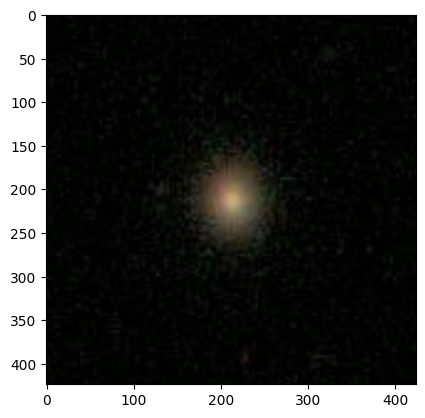

In [ ]:
plt.imshow(plt.imread('/content/f-AnoGAN/your_own_dataset/images_grouped/Normal/1734.jpg'))

In [ ]:
shutil.rmtree(source_dir)

In [ ]:
shutil.rmtree('/content/f-AnoGAN/your_own_dataset/images_grouped/Elliptical')

In [ ]:
# shutil.move('/content/f-AnoGAN/your_own_dataset/images_grouped/Anomalous', '/content/f-AnoGAN/your_own_dataset/Anomalous')

'/content/f-AnoGAN/your_own_dataset/Anomalous'

Step 1

In [ ]:
!python train_wgangp.py "/content/f-AnoGAN/your_own_dataset/images_grouped" --n_epochs 50

[Epoch  0/50] [Batch    0/7487] [D loss: 9.282032] [G loss: -0.001801]
[Epoch  0/50] [Batch    5/7487] [D loss: 9.014524] [G loss: -0.001771]
[Epoch  0/50] [Batch   10/7487] [D loss: 8.805895] [G loss: -0.002624]
[Epoch  0/50] [Batch   15/7487] [D loss: 8.525002] [G loss: -0.001325]
[Epoch  0/50] [Batch   20/7487] [D loss: 7.777434] [G loss: 0.000288]
[Epoch  0/50] [Batch   25/7487] [D loss: 7.013582] [G loss: -0.005432]
[Epoch  0/50] [Batch   30/7487] [D loss: 5.730198] [G loss: -0.001847]
[Epoch  0/50] [Batch   35/7487] [D loss: 4.096977] [G loss: -0.003062]
[Epoch  0/50] [Batch   40/7487] [D loss: 2.050071] [G loss: -0.012963]
[Epoch  0/50] [Batch   45/7487] [D loss: -0.425783] [G loss: -0.017896]
[Epoch  0/50] [Batch   50/7487] [D loss: -1.720919] [G loss: -0.052901]
[Epoch  0/50] [Batch   55/7487] [D loss: -3.444121] [G loss: -0.037111]
[Epoch  0/50] [Batch   60/7487] [D loss: -6.445870] [G loss: -0.052560]
[Epoch  0/50] [Batch   65/7487] [D loss: -9.636429] [G loss: -0.195830]
[E

Saving the generated images

In [ ]:
%cd /content/f-AnoGAN/your_own_dataset

/content/f-AnoGAN/your_own_dataset


In [ ]:
!zip -r wGAN_images.zip /content/f-AnoGAN/your_own_dataset/results/images
from google.colab import files
files.download('wGAN_images.zip')

  adding: content/f-AnoGAN/your_own_dataset/results/images/ (stored 0%)
  adding: content/f-AnoGAN/your_own_dataset/results/images/148000.png (deflated 0%)
  adding: content/f-AnoGAN/your_own_dataset/results/images/103600.png (deflated 0%)
  adding: content/f-AnoGAN/your_own_dataset/results/images/335200.png (deflated 0%)
  adding: content/f-AnoGAN/your_own_dataset/results/images/014800.png (deflated 0%)
  adding: content/f-AnoGAN/your_own_dataset/results/images/224800.png (deflated 0%)
  adding: content/f-AnoGAN/your_own_dataset/results/images/158000.png (deflated 0%)
  adding: content/f-AnoGAN/your_own_dataset/results/images/003600.png (deflated 0%)
  adding: content/f-AnoGAN/your_own_dataset/results/images/111200.png (deflated 0%)
  adding: content/f-AnoGAN/your_own_dataset/results/images/033200.png (deflated 0%)
  adding: content/f-AnoGAN/your_own_dataset/results/images/304800.png (deflated 0%)
  adding: content/f-AnoGAN/your_own_dataset/results/images/311200.png (deflated 0%)
  ad

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Step 2

In [ ]:
!python train_encoder_izif.py --n_epochs 100 "/content/f-AnoGAN/your_own_dataset/images"

Streaming output truncated to the last 5000 lines.
[Epoch  67/100] [Batch 410/770] [E loss: 0.008894]
[Epoch  67/100] [Batch 415/770] [E loss: 0.010796]
[Epoch  67/100] [Batch 420/770] [E loss: 0.010448]
[Epoch  67/100] [Batch 425/770] [E loss: 0.010434]
[Epoch  67/100] [Batch 430/770] [E loss: 0.009682]
[Epoch  67/100] [Batch 435/770] [E loss: 0.010254]
[Epoch  67/100] [Batch 440/770] [E loss: 0.010199]
[Epoch  67/100] [Batch 445/770] [E loss: 0.011086]
[Epoch  67/100] [Batch 450/770] [E loss: 0.010307]
[Epoch  67/100] [Batch 455/770] [E loss: 0.010778]
[Epoch  67/100] [Batch 460/770] [E loss: 0.010565]
[Epoch  67/100] [Batch 465/770] [E loss: 0.012028]
[Epoch  67/100] [Batch 470/770] [E loss: 0.008238]
[Epoch  67/100] [Batch 475/770] [E loss: 0.010053]
[Epoch  67/100] [Batch 480/770] [E loss: 0.009500]
[Epoch  67/100] [Batch 485/770] [E loss: 0.009498]
[Epoch  67/100] [Batch 490/770] [E loss: 0.010092]
[Epoch  67/100] [Batch 495/770] [E loss: 0.008726]
[Epoch  67/100] [Batch 500/770]

Step 3

In [ ]:
shutil.move('/content/f-AnoGAN/your_own_dataset/Anomalous', '/content/f-AnoGAN/your_own_dataset/images_grouped/Anomalous')
shutil.move('/content/f-AnoGAN/your_own_dataset/images_grouped/Spiral', '/content/f-AnoGAN/your_own_dataset/Spiral')

'/content/f-AnoGAN/your_own_dataset/Spiral'

In [ ]:
import os
import shutil
import random

source_base = '/content/f-AnoGAN/your_own_dataset/'
elliptical_source = os.path.join(source_base, 'Normal')

# Create a new directory to move Elliptical images
elliptical_destination = '/content/f-AnoGAN/your_own_dataset/normal_subset2'
os.makedirs(elliptical_destination, exist_ok=True)

# Percentage of data to keep (.1%)
elliptical_keep_percent = 0.00000707063

# Get list of images in the Elliptical folder
elliptical_images = os.listdir(elliptical_source)

# Calculate the number of images to keep
elliptical_keep_count = int(len(elliptical_images) * elliptical_keep_percent)

# Randomly select images to keep
selected_elliptical_images = random.sample(elliptical_images, elliptical_keep_count)

# Move selected Elliptical images to the new destination
for image in selected_elliptical_images:
    src = os.path.join(elliptical_source, image)
    dst = os.path.join(elliptical_destination, image)
    shutil.move(src, dst)

print("Elliptical images moved to a subset folder.")

Elliptical images moved to a subset folder.


In [ ]:
shutil.rmtree("/content/f-AnoGAN/your_own_dataset/normal_subset2")

In [ ]:
elliptical_subset_dir = '/content/f-AnoGAN/your_own_dataset/elliptical_subset2'
len(os.listdir(elliptical_subset_dir))

187

In [ ]:
len(os.listdir('/content/f-AnoGAN/your_own_dataset/images_grouped/Elliptical'))

94714

In [ ]:
# shutil.move('/content/f-AnoGAN/your_own_dataset/images_grouped/normal_subset2', '/content/f-AnoGAN/your_own_dataset/normal_subset2')
# shutil.rmtree('/content/f-AnoGAN/your_own_dataset/images_grouped/elliptical_subset2')
shutil.move('/content/f-AnoGAN/your_own_dataset/normal_subset2', '/content/f-AnoGAN/your_own_dataset/images_grouped/normal_subset2')

'/content/f-AnoGAN/your_own_dataset/images_grouped/normal_subset2'

In [ ]:
# !python test_anomaly_detection.py "/content/f-AnoGAN/your_own_dataset/images_testing_rev1"
!python test_anomaly_detection.py "/content/f-AnoGAN/your_own_dataset/images_grouped"

Traceback (most recent call last):
  File "/content/f-AnoGAN/your_own_dataset/test_anomaly_detection.py", line 60, in <module>
    main(opt)
  File "/content/f-AnoGAN/your_own_dataset/test_anomaly_detection.py", line 33, in main
    test_anomaly_detection(opt, generator, discriminator, encoder,
  File "/usr/local/lib/python3.10/dist-packages/fanogan-0.0.1-py3.10.egg/fanogan/test_anomaly_detection.py", line 8, in test_anomaly_detection
    
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 2041, in load_state_dict
    raise RuntimeError('Error(s) in loading state_dict for {}:\n\t{}'.format(
RuntimeError: Error(s) in loading state_dict for Generator:
	Missing key(s) in state_dict: "l1.0.weight", "l1.0.bias", "conv_blocks.0.weight", "conv_blocks.0.bias", "conv_blocks.0.running_mean", "conv_blocks.0.running_var", "conv_blocks.2.weight", "conv_blocks.2.bias", "conv_blocks.3.weight", "conv_blocks.3.bias", "conv_blocks.3.running_mean", "conv_blocks.3.running_va

Step 4

In [ ]:
shutil.rmtree("/content/f-AnoGAN/your_own_dataset/results/images_diff")

In [ ]:
!python save_compared_images.py "/content/f-AnoGAN/your_own_dataset/images_grouped" --n_iters 5 --n_grid_lines 10

In [ ]:
from pathlib import Path

source_folder = "/content/f-AnoGAN/your_own_dataset/results/images_diff"
destination_folder = "/content/drive/MyDrive/AnoGAN_Images"

Path(destination_folder).mkdir(parents=True, exist_ok=True)

for image_file in Path(source_folder).iterdir():
    if image_file.is_file():
        shutil.move(str(image_file), str(Path(destination_folder) / image_file.name))

print("Images moved successfully.")

Images moved successfully.


##Visualization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix

In [ ]:
df3 = pd.read_csv("results/score.csv")
# df3.drop(columns="img_filename", inplace=True)

In [ ]:
# Specify the subfolder path
subfolder_path = '/content/f-AnoGAN/your_own_dataset/images_grouped/Anomalous'

# Get a list of all file names in the subfolder
file_names = os.listdir(subfolder_path)

# Iterate through both rows of df3 and files in the subfolder
for index, row in df3.iterrows():
    # Check if there are files in the subfolder
    if file_names:
        # Pop the first file name from the list
        new_img_filename = file_names.pop(0)
        # Update the DataFrame's "img_filename" column with the new name
        df3.at[index, 'img_filename'] = new_img_filename

# Print the updated DataFrame
df3

,label,img_filename,img_distance,anomaly_score,z_distance
0,0,275275.jpg,0.036303,0.173372,0.512802
1,0,941.jpg,0.007959,0.027377,0.415690
2,0,166314.jpg,0.017111,0.073012,0.328846
3,0,37458.jpg,0.072955,0.348346,0.493452
4,0,126254.jpg,0.057469,0.159884,0.478516
...,...,...,...,...,...
239568,1,100.jpg,0.011867,0.043328,0.267667
239569,1,100.jpg,0.005755,0.010592,0.115529
239570,1,100.jpg,0.003596,0.010436,0.158721
239571,1,100.jpg,0.003232,0.012825,0.073160


In [ ]:
df3

,label,img_distance,anomaly_score,z_distance
0,0,0.036712,0.150345,0.591433
1,0,0.009615,0.041899,0.316419
2,0,0.017111,0.073012,0.328846
3,0,0.072955,0.348346,0.493452
4,0,0.057469,0.159884,0.478516
...,...,...,...,...
540,0,0.235135,0.875345,0.656531
541,0,0.052520,0.180113,0.626642
542,0,0.009836,0.019212,0.257365
543,0,0.084170,0.384747,0.616278


In [ ]:
df3["img_filename"].value_counts()

100.jpg       239029
100147.jpg       544
Name: img_filename, dtype: int64

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.model_zoo import tqdm

def test_anomaly_detection(opt, generator, discriminator, encoder,
                           dataloader, device, kappa=1.0):
    generator.load_state_dict(torch.load("results/generator"))
    discriminator.load_state_dict(torch.load("results/discriminator"))
    encoder.load_state_dict(torch.load("results/encoder"))

    generator.to(device).eval()
    discriminator.to(device).eval()
    encoder.to(device).eval()

    criterion = nn.MSELoss()

    with open("results/score.csv", "w") as f:
        f.write("label,img_filename,img_distance,anomaly_score,z_distance\n")

    for (img, label, img_filename) in tqdm(dataloader):

        real_img = img.to(device)

        real_z = encoder(real_img)
        fake_img = generator(real_z)
        fake_z = encoder(fake_img)

        real_feature = discriminator.forward_features(real_img)
        fake_feature = discriminator.forward_features(fake_img)

        # Scores for anomaly detection
        img_distance = criterion(fake_img, real_img)
        loss_feature = criterion(fake_feature, real_feature)
        anomaly_score = img_distance + kappa * loss_feature

        z_distance = criterion(fake_z, real_z)

        with open("results/score.csv", "a") as f:
            f.write(f"{label.item()},{img_filename[0]},{img_distance},"
                    f"{anomaly_score},{z_distance}\n")

IndentationError: ignored

<Axes: xlabel='anomaly_score', ylabel='Count'>

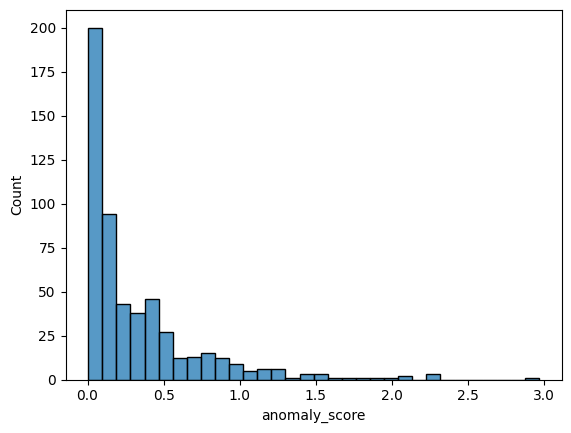

In [ ]:
sns.histplot(df3["anomaly_score"])

<Axes: >

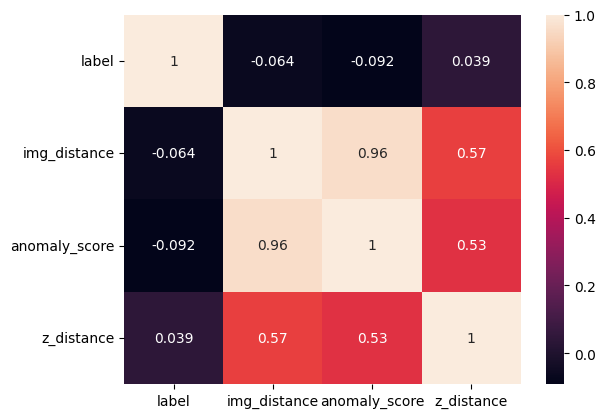

In [ ]:
sns.heatmap(df3.corr(), annot=True)

In [ ]:
trainig_label = 1
labels = np.where(df3["label"].values == trainig_label, 0, 1)
anomaly_score = df3["anomaly_score"].values
img_distance = df3["img_distance"].values
z_distance = df3["z_distance"].values

In [ ]:
fpr, tpr, _ = roc_curve(labels, img_distance)
precision, recall, _ = precision_recall_curve(labels, img_distance)
roc_auc = auc(fpr, tpr)
pr_auc =  auc(recall, precision)

In [ ]:
mean_anom_val = df3["anomaly_score"].mean()

In [ ]:
pred_labels = (anomaly_score >= mean_anom_val).astype(int)

In [ ]:
print(confusion_matrix(labels, pred_labels))

[[  1   0]
 [356 188]]


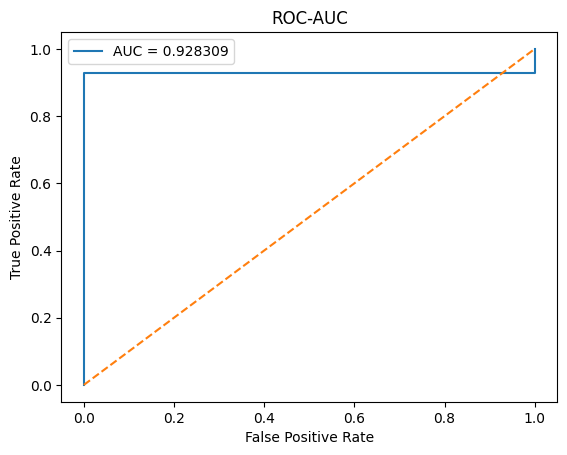

In [ ]:
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC-AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

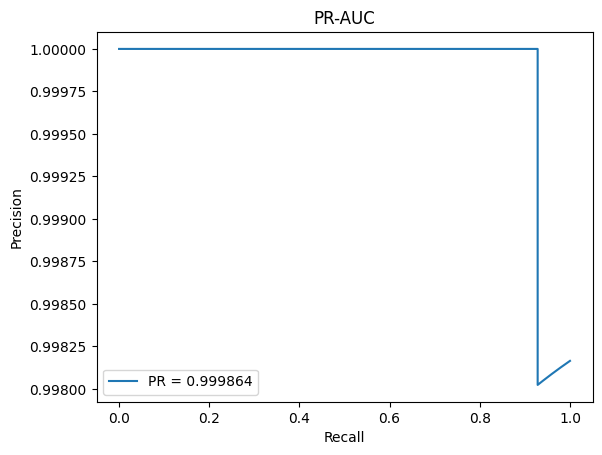

In [ ]:
plt.plot(recall, precision, label=f"PR = {pr_auc:3f}")
plt.title("PR-AUC")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

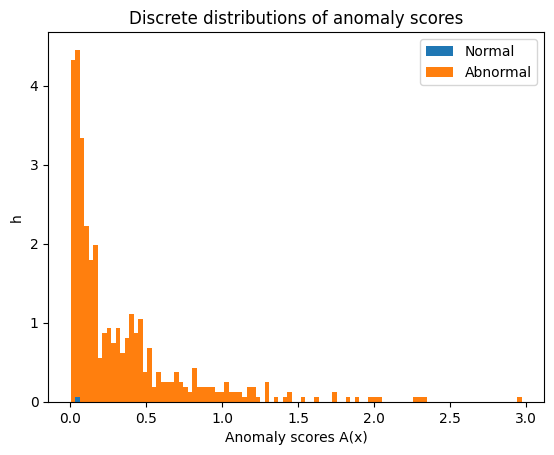

In [ ]:
plt.hist([anomaly_score[labels == 0], anomaly_score[labels == 1]],
          bins=100, density=True, stacked=True,
          label=["Normal", "Abnormal"])
plt.title("Discrete distributions of anomaly scores")
plt.xlabel("Anomaly scores A(x)")
plt.ylabel("h")
plt.legend()
plt.show()